In [4]:
# %load /home/glebi/git/experiment-automation/processing_tools.py
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import scienceplots

plt.style.use(['science', 'russian-font'])
plt.style.use(["light"])

matplotlib.rcParams.update({
    'figure.figsize': [6, 4],
    'savefig.facecolor': 'white',
    'figure.dpi': 150.0,
    'font.size': 12.0,
})

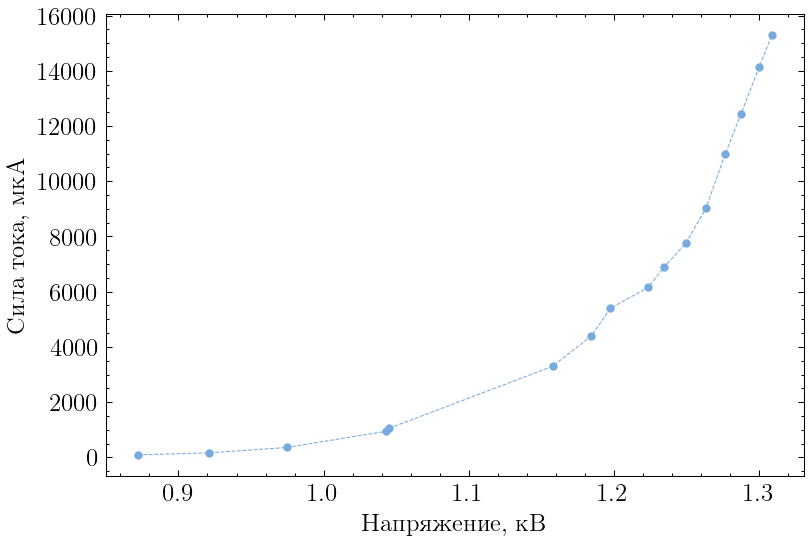

In [102]:
df = pd.read_csv("VAH.csv")
cols = df.columns

plt.plot(df[cols[0]] * 1e-3, df[cols[1]]*1e1, marker=".", lw=.5, ls="--")
plt.xlabel("Напряжение, кВ")
plt.ylabel("Сила тока, мкА")

plt.savefig("hand-measure-VAH.png")
plt.show()

сопротивление нашей цепи

In [16]:
1263.4 / (903e-7)

13991140.642303433

максимальное напряжение на резисторе, который снимает ток

In [17]:
1600e-7 * 52e3

8.32

аналитическая функция вах

In [18]:
# def vah_func(u):
#     return S_e * (1.537e10 / )

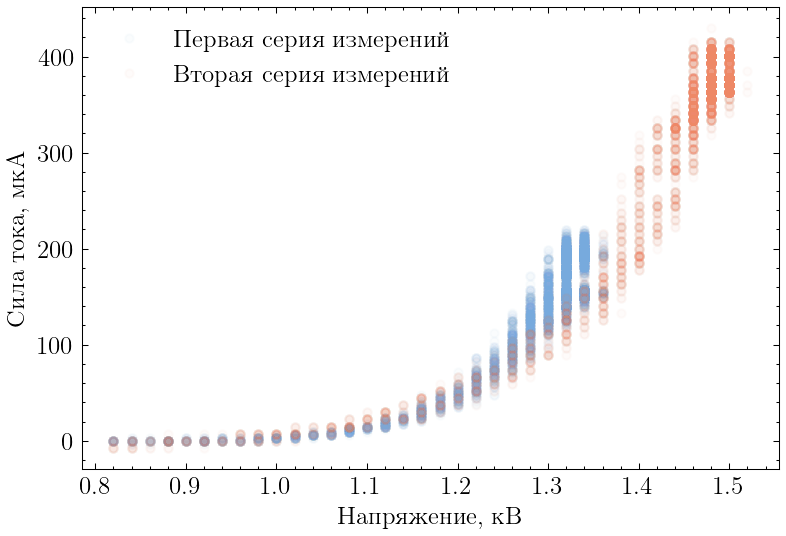

In [135]:
U_min = 800

for i in range(1, 6):
    df = pd.read_csv(f"RISING-{i}.csv", header = None)
    df = df.loc[lambda x : x[4] > U_min]
    
    U = df[4] * 1e-3 # кВ
    U_res = df[10]
    R = 26.99e3 # Ом
    I = U_res / R * 1e6 # мкА
    
    title = ("Первая серия измерений" if (i // 4 == 0) else "Вторая серия измерений")
    plt.plot(U, I, lw=5, alpha=0.03, ls="", marker="o", markersize=4, color=f"C{i // 4}", label=(title if i % 4 == 1 else None))
    
    
plt.xlabel(fr"Напряжение, кВ")
plt.ylabel(fr"Сила тока, мкА")
# plt.yscale("log")

plt.legend()
plt.savefig("rising-RAW-DATA.png")
plt.show()

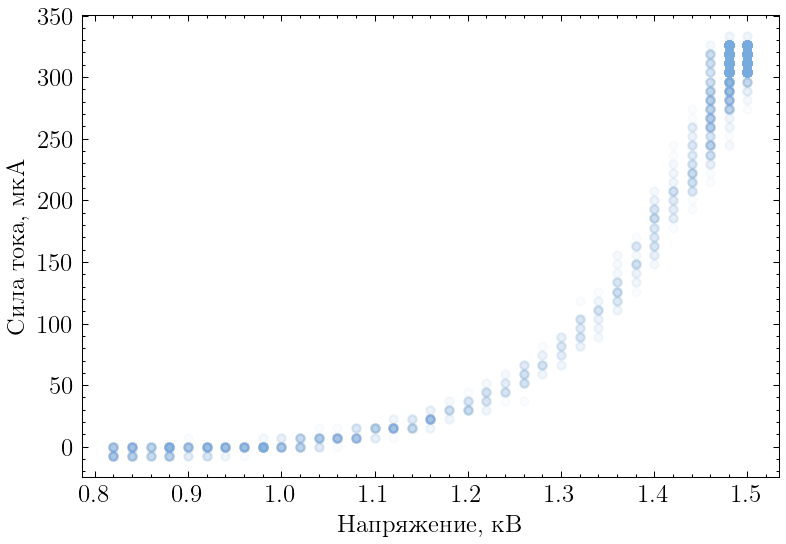

In [142]:
U_min = 800

for i in range(1, 4):
    df = pd.read_csv(f"BOTH-{i}.csv", header = None)
    df = df.loc[lambda x : x[4] > U_min]
    
    U = df[4] * 1e-3 # кВ
    U_res = df[10]
    R = 26.99e3 # Ом
    I = U_res / R * 1e6 # мкА
    
    plt.plot(U, I, lw=5, alpha=0.03, ls="", marker="o", markersize=4, color=f"C0")
    
    
plt.xlabel(fr"Напряжение, кВ")
plt.ylabel(fr"Сила тока, мкА")
# plt.yscale("log")

plt.savefig("both-RAW-DATA.png")
plt.show()